# Combine dat files form unattnded ApRES surveys on Thwaites glacier into netcdfs for archiving
We will archive netcdfs of the data without the profiles, but including the stacked chirps.

In [ ]:
import sys
sys.path.append("/Users/jkingslake/Documents/science/ApRES/xapres")
import xapres as xa
import numpy as np
import xarray as xr
import os

sites = ["ApRES_LTG", "ApRES_Lake1", "ApRES_Lake2", "ApRES_Takahe1_204", "ApRES_Takahe2_203"]
tg_1 = xa.load.from_dats()
source = "/Users/jkingslake/Documents/data/thwaites_apres/original/continuous/"

archive_location ='/Users/jkingslake/Documents/data/thwaites_apres/archiving/unattended'

def remove_constants_attr(ds):
    for c in ds.attrs['constants']:
        ds.attrs[c] = ds.attrs['constants'][c]
    del ds.attrs['constants']
    return ds

for site in sites:
    dat_directory = os.path.join(source, site, "dat_files")
    filepaths = tg_1.list_files(directory=dat_directory)
    print(f"there are {len(filepaths)} files from {site}")
    one_dat = tg_1.load_all(directory = dat_directory, file_numbers_to_process=[7], computeProfiles = False, disable_progress_bar=True)
    print(f"total size of dataset without profiles computed = {one_dat.nbytes/1e9 * len(filepaths):.2f} GB in memory")

    if site == 'ApRES_LTG': 
        start_dat_file_number = 4  # the first 4 use the same attenuator settings, but they are not regularly spaces in time with the other data
    elif site == 'ApRES_Lake1':
        start_dat_file_number = 3  # the first 3 use different attenuator settings. THis is the first one which is regularly spaced in time with the other data
    elif site == 'ApRES_Lake2':
        start_dat_file_number = 4  # This is the first one which is regularly spaced in time with the other data
    elif site == 'ApRES_Takahe1_204':
        start_dat_file_number = 0
    elif site == 'ApRES_Takahe2_203':
        start_dat_file_number = 3 # something is up with the first 3 files some seem to have no data and one is the wrong size. 
    else:
        raise ValueError(f"Unknown site {site}")

    dat_size = os.path.getsize(filepaths[start_dat_file_number+5])
    print(f"dat file size = {dat_size/1e6:.2f} MB on disk")

    f = sorted(filepaths)[start_dat_file_number:]

    # split list into block N big
    N = int(17*104e6/dat_size)  # number of files to process in each block
    file_lists = [f[i:i + N] for i in range(0, len(f), N)]
    print(f'created {len(file_lists)} file lists from {len(f)} files')
    print(f'list sizes: {[len(x) for x in file_lists]}')


    nc_locations = [f'{archive_location}/{site}/netcdf/part_{i}.nc' for i in range(len(file_lists))]
    os.makedirs(f"{archive_location}/{site}/netcdf", exist_ok=True) 
    

    for i, file_list in enumerate(file_lists):
        print(f"Processing {len(file_list)} files")
        ds = tg_1.load_all(directory = dat_directory, 
                        computeProfiles = False,
                        file_names_to_process=file_list,
                        disable_progress_bar=False)
        
        # add stacked chirps
        ds['chirp_stacked'] = ds.chirp.mean(dim='chirp_num', keep_attrs=True)
        ds.chirp_stacked.attrs['long_name'] = 'stacked de-ramped chirp'

        ds["chirp_time"].attrs["units"] = "unscaled seconds"
        ds = remove_constants_attr(ds)
        
        ds.to_netcdf(nc_locations[i])


there are 181 files from ApRES_LTG
total size of dataset without profiles computed = 11.64 GB in memory
dat file size = 8.00 MB on disk
created 1 file lists from 177 files
list sizes: [177]
Processing 177 files


100%|██████████| 177/177 [00:06<00:00, 28.06it/s]


there are 185 files from ApRES_Lake1
total size of dataset without profiles computed = 11.90 GB in memory
dat file size = 16.00 MB on disk
created 2 file lists from 182 files
list sizes: [110, 72]
Processing 110 files


100%|██████████| 110/110 [00:03<00:00, 27.68it/s]


Processing 72 files


100%|██████████| 72/72 [00:03<00:00, 23.08it/s]


there are 60 files from ApRES_Lake2
total size of dataset without profiles computed = 26.90 GB in memory
dat file size = 112.01 MB on disk
created 4 file lists from 56 files
list sizes: [15, 15, 15, 11]
Processing 15 files


100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


Processing 15 files


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


Processing 15 files


100%|██████████| 15/15 [00:02<00:00,  5.68it/s]


Processing 11 files


100%|██████████| 11/11 [00:02<00:00,  4.23it/s]


there are 29 files from ApRES_Takahe1_204
total size of dataset without profiles computed = 12.07 GB in memory
dat file size = 104.02 MB on disk
created 2 file lists from 29 files
list sizes: [16, 13]
Processing 16 files


100%|██████████| 16/16 [00:03<00:00,  4.38it/s]


Processing 13 files


100%|██████████| 13/13 [00:03<00:00,  3.91it/s]


there are 34 files from ApRES_Takahe2_203
total size of dataset without profiles computed = 14.16 GB in memory
dat file size = 104.02 MB on disk
created 2 file lists from 31 files
list sizes: [16, 15]
Processing 16 files


100%|██████████| 16/16 [00:03<00:00,  5.31it/s]


Processing 15 files


100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


In [15]:
ds_r = xr.open_mfdataset(f"{archive_location}/{site}/netcdf/*")
ds_r.load()

<xarray.Dataset> Size: 12GB
Dimensions:          (time: 365, chirp_num: 100, attenuator_setting_pair: 1,
                      chirp_time: 40001)
Coordinates:
  * time             (time) datetime64[ns] 3kB 2023-01-20T02:07:57 ... 2024-0...
  * chirp_time       (chirp_time) float64 320kB 0.0 2.5e-05 5e-05 ... 1.0 1.0
  * chirp_num        (chirp_num) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
    filename         (time) <U23 34kB 'DATA2023-01-20-0207.DAT' ... 'DATA2024...
    folder_name      (time) <U9 13kB 'dat_files' 'dat_files' ... 'dat_files'
    burst_number     (time) int64 3kB 0 1 2 3 4 5 6 7 8 9 ... 2 3 4 5 6 7 8 9 10
    AFGain           (attenuator_setting_pair) int64 8B -4
    attenuator       (attenuator_setting_pair) float64 8B 14.0
    orientation      (time) <U7 10kB 'unknown' 'unknown' ... 'unknown' 'unknown'
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (time, chirp_num, attenuator_setting_pair, chirp_time) float64 12GB ...
    latitude         (time) float64 3kB -76.44 -76.44 -76.44 ... -76.44 -76.44
    longitude        (time) float64 3kB -110.1 -110.1 -110.1 ... -110.1 -110.1
    battery_voltage  (time) float64 3kB 14.36 14.04 14.05 ... 12.89 12.89 12.87
    temperature_1    (time) float64 3kB -8.219 -11.74 -17.04 ... -20.18 -22.92
    temperature_2    (time) float64 3kB -10.29 -15.78 -13.82 ... -23.81 -24.01
    chirp_stacked    (time, attenuator_setting_pair, chirp_time) float64 117MB ...
Attributes:
    processing:  Created on 2025-07-01 19:50:41.645951
    c:           300000000.0
    K:           200000000.0
    f_1:         200000000.0
    f_2:         400000000.0
    dt:          2.5e-05
    ep:          3.18
    B:           200000000.0
    f_c:         300000000.0

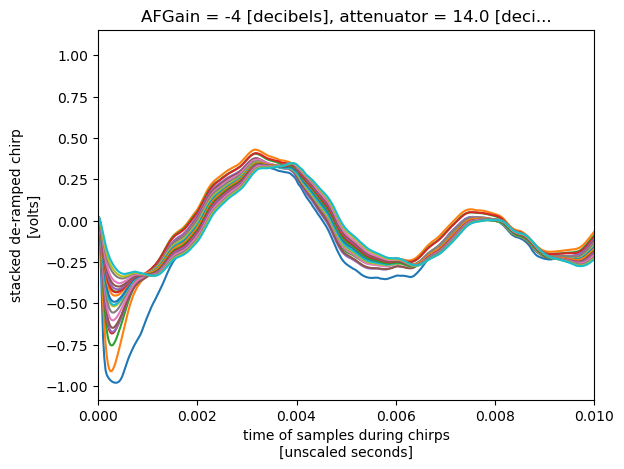

In [27]:
ds_r.chirp_stacked.isel(time = slice(0,20)).squeeze().plot(hue='time', add_legend=False, xlim= (0, 0.01))

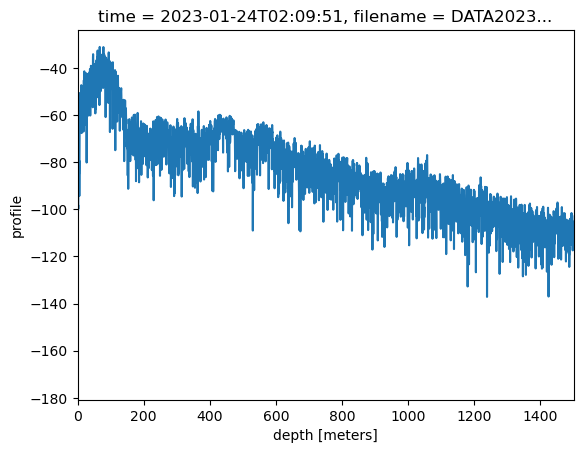

In [31]:
ds_r.chirp_stacked.computeProfile().dB().squeeze().isel(time=4).plot(hue='time', xlim = (0, 1500))

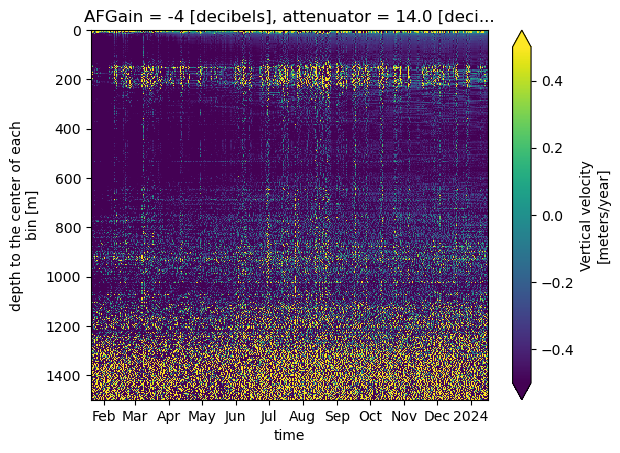

In [ ]:
ds_r.chirp_stacked.computeProfile().displacement_timeseries().velocity.plot(x = 'time', ylim = (1500, 0), vmin = -0.5, vmax = 0.5)

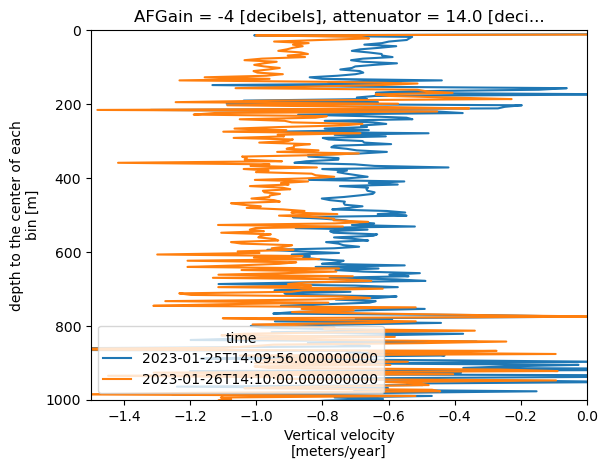

In [46]:
ds_r.chirp_stacked.computeProfile().displacement_timeseries().velocity.isel(time=slice(5,7)).plot(y='bin_depth', hue='time', ylim = (1000,00), xlim = (-1.5, 0))

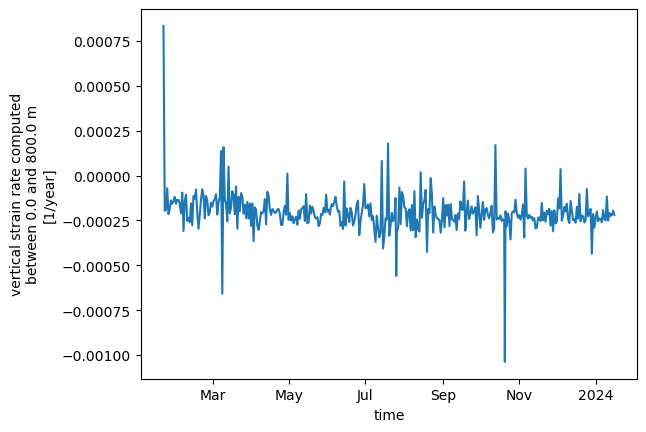

In [34]:
ds_r.chirp_stacked.computeProfile().displacement_timeseries().strain_rate.plot()